In [2]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,7)

In [3]:
df = pd.read_csv("Trial1_FallDetection.csv",header=None)
df.columns=['X','Y','Z','Magnitude']
df

,X,Y,Z,Magnitude
0,752,-160,616,985.170036
1,744,-192,624,989.836350
2,736,-176,632,985.949289
3,760,-168,616,992.612714
4,752,-160,624,990.191901
...,...,...,...,...
48370,480,-816,-280,987.246676
48371,480,-816,-312,996.794864
48372,464,-832,-288,995.220579
48373,472,-816,-288,985.689606


In [4]:
def plot(df,start,end,showx=False,showy=False,showz=False,showTotal=True):
    legend_lst=[]
    if(showx):
        sns.lineplot(y = 'X', x = df.index[start:end], data = df[start:end])
        legend_lst+='X'
    if(showy):
        sns.lineplot(y = 'Y', x = df.index[start:end], data = df[start:end])
        legend_lst+='Y'
    if(showz):
        sns.lineplot(y = 'Z', x = df.index[start:end], data = df[start:end])
        legend_lst+='Z'
    if(showTotal):
        sns.lineplot(y = 'Magnitude', x = df.index[start:end], data = df[start:end])
        legend_lst+='Magnitude'
    plt.legend(legend_lst)
    plt.ylabel("magnitude")
    plt.title("Accelerometer Plot from "+str(start)+" till "+str(end), fontsize = 15)
    plt.show()

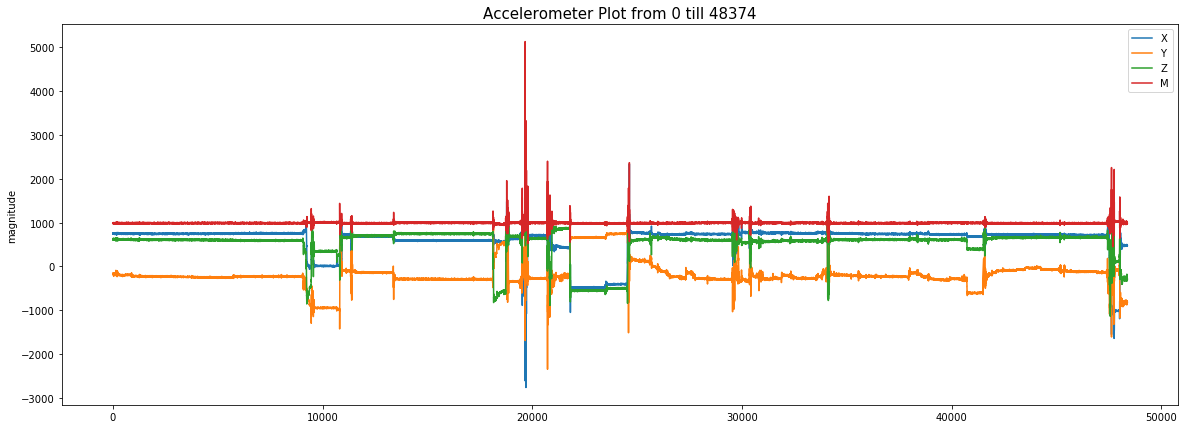

In [8]:
plot(df,0,df.index[-1],True,True,True,True)

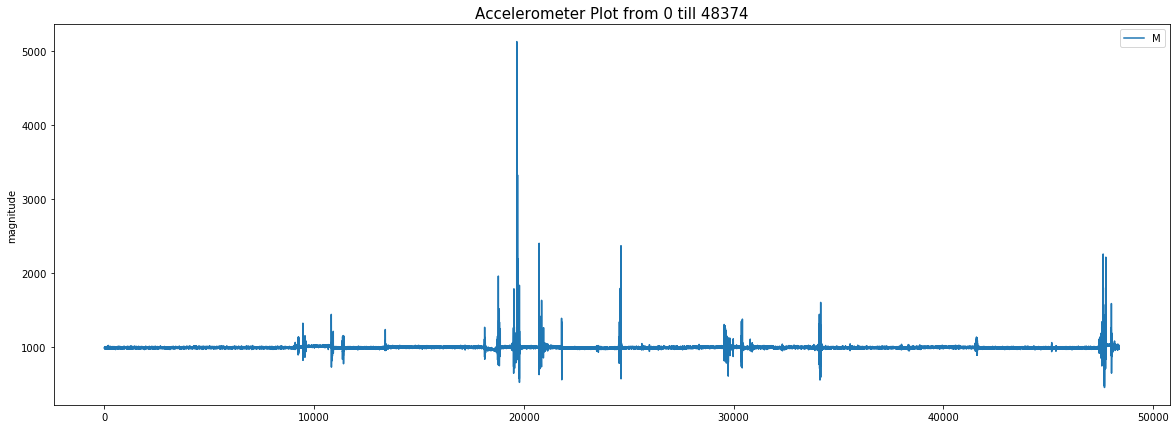

In [14]:
plot(df,0,df.index[-1])

In [9]:
def extract_mean_max_min(data,start_time,win_size=50): #25Hz sampling rate
    avg=0
    min_mag=1e9
    max_mag=-1e9
    diff_max_min=0
    for i in range(start_time,start_time+win_size):
        if(i>=len(data)):
            break
        mag=(data.loc[i,'Magnitude'])
        avg+=mag
        min_mag=min(min_mag,mag)
        max_mag=max(max_mag,mag)
        diff_max_min=max(diff_max_min,max_mag-min_mag)
    return round(avg/win_size,2),min_mag,max_mag,diff_max_min
    

In [35]:
## FREE FALL DETECTION:
# def detect_free_fall(df,threshold_tending_0,impact_activity,inactivity)#takes data,
# prev=False
for i in range(0,df.index[-1],50):
        if((i>=250 and i<500) or (i>=1050 and i<1500) or (i>=2000 and i<2300) or (i>=2700 and i<=3000)):
                print(i,extract_mean_max_min(df,i,50))



250 (999.89, 965.1528376, 1040.676703, 75.52386540000009)
300 (848.89, 17.88854382, 1025.405286, 1007.5167421799999)
350 (938.78, 13.85640646, 6053.843738, 6039.98733154)
400 (994.77, 958.1983093, 1014.487063, 56.28875370000003)
450 (996.6, 981.2318788, 1006.157045, 24.925166200000035)
1050 (1115.46, 409.1747793, 2458.461307, 2049.2865277)
1100 (897.34, 96.66436779, 1462.294088, 1365.6297202100002)
1150 (993.96, 689.3475176, 1438.599319, 749.2518014)
1200 (985.16, 935.0764675, 1027.026777, 91.9503095)
1250 (988.5, 945.6933964, 1025.748507, 80.05511060000003)
1300 (709.35, 24.0, 5276.94457, 5252.94457)
1350 (985.63, 970.6410253, 1001.598722, 30.95769669999993)
1400 (985.01, 969.7174846, 1002.365203, 32.64771839999992)
1450 (984.57, 968.9582034, 1001.662618, 32.70441459999995)
2000 (984.61, 912.2806586, 1001.087409, 88.80675039999994)
2050 (1080.89, 207.8460969, 2600.504566, 2392.6584691000003)
2100 (978.8, 701.1305157, 1387.92507, 686.7945543)
2150 (783.61, 85.79044236, 3444.991727, 335

In [12]:
## FREE FALL DETECTION: v2
#25 hz 1s , win size=50 2s  3->windows 6s, winsize10
def detect_free_fall(df,threshold_tending_0,impact_activity,inactivity,win_size=50,overlap_win=25):
    
    for i in range(0,df.index[-1]-win_size,overlap_win): 
        
        avg_mag,min_mag,max_mag,diff_max_min=extract_mean_max_min(df,i,win_size)

        if(min_mag<=threshold_tending_0):#fall detected
            print(i,"Free Fall detected")
            #case where impact and free fall in same window
            if(diff_max_min>=impact_activity):#min max diff
                print(i,"Impact also deteced-SAME WINDOW")
                temp_size=10 #window size for calculating average
                no_of_iterations = 15 #considering 2s [10*10==100 -> 25Hz in 1s]
                sum_diff=0
                for j in range(0,no_of_iterations+1):
                    sum_diff+=extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3]
                avg_sum_diff = sum_diff/no_of_iterations
                if(avg_sum_diff<=inactivity):
                    print(i,"Inactivness, FALL CONFIRMED")
                else:
                    print(avg_sum_diff)
        
            #Searching for Impact in next window
            elif(extract_mean_max_min(df,i+overlap_win,overlap_win)[3]>=impact_activity):#min max diff
                print(i,"Impact also deteced-NEXT WINDOW")
                temp_size=5 #window size for calculating average
                no_of_iterations = 30 #considering 2s [10*10==100 -> 25Hz in 1s]
                sum_diff=0
                for j in range(0,no_of_iterations+1):
                    sum_diff+=extract_mean_max_min(df,i+win_size+ (j*temp_size),temp_size)[3]
                avg_sum_diff = sum_diff/no_of_iterations
                if(avg_sum_diff<=inactivity):
                    print(i,"Inactivness, FALL CONFIRMED")
                else:
                    print(avg_sum_diff)

In [21]:
detect_free_fall(df,95,2000,200)

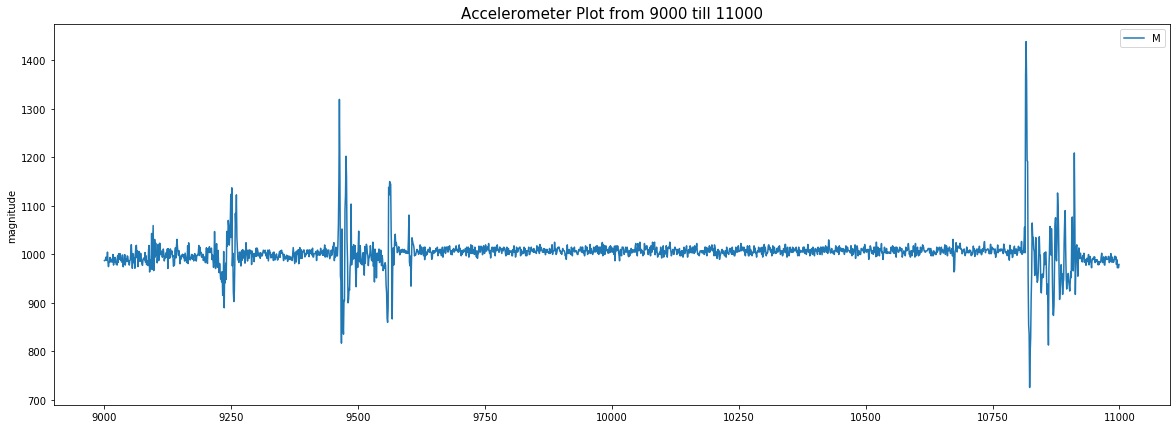

In [20]:
plot(df,9000,11000)